## Projet Societe Generale

*Léon Thomir - Irénée De Leusse - Amaury - Louis Bolzinger*  
CentraleSupélec 3A MMF - Société Générale

In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import gamma
from math import pi
#pip install fbm==0.1.0
from fbm import FBM
import warnings
warnings.filterwarnings('ignore')

Import et cleaning de la data

In [2]:
file = "/Users/user/Documents/Cours/CentraleSupelec/Projet/Docs/Data issuers.xlsx"
market_cap = pd.read_excel(file, sheet_name="Mod Market Cap")
market_cap = market_cap.set_index("Dates").loc['2019-10-28':'2020-10-13']
debt = pd.read_excel(file, sheet_name="Gross Debt", nrows=1)

## Probabilité de défault & Merton

### Méthodes

#### Modèle de Merton 'Classique'

In [3]:
def BSM(ticker, market_cap, debt, T=1, frequency=252, rf=0, epsilon=10e-5):
    company_debt = debt[[ticker]].iloc[0, 0]
    company_market_cap = market_cap[[ticker]].iloc[:, 0]
    current_time = 0
    equity_value = 0
    sigma_A = 0
    sigma_A_former = 0
    asset_values = []

    def d1_m(x, sigma_A, current_time):
        return ((np.log(x / company_debt)) + (rf + 0.5 * sigma_A ** 2) * current_time) / (
                sigma_A * np.sqrt(current_time))

    def d2_m(x, sigma_A, current_time):
        return d1_m(x, sigma_A, current_time) - sigma_A * np.sqrt(current_time)

    # inverse the black scholes formula
    def merton_formula(x, rf, current_time):
        d1_term = x * norm.cdf(d1_m(x, sigma_A, current_time))
        d2_term = company_debt * np.exp(-rf * current_time) * norm.cdf(d2_m(x, sigma_A, current_time))
        return d1_term - d2_term - equity_value

    sigma_E = np.std(np.diff(np.log(company_market_cap), n=1)) * np.sqrt(frequency)
    sigma_A = sigma_E

    while np.abs(sigma_A - sigma_A_former) > epsilon:

        asset_values = []

        for dt in range(company_market_cap.shape[0]):
            current_time = T + (frequency - dt - 1) / frequency
            equity_value = company_market_cap[dt]
            # find zero of Merton function, ie asset_value at the current_time
            asset_values.append(optimize.newton(merton_formula, company_debt, args=(rf, current_time)))

        # update of sigma_A and sigma_A_former
        sigma_A_former = sigma_A
        sigma_A = np.std(np.diff(np.log(asset_values), n=1)) * np.sqrt(frequency)

    # compute distance to default and default probability
    distance_to_default = d2_m(asset_values[-1], sigma_A, current_time)
    default_probability = (1 - norm.cdf(distance_to_default)) * 100

    distance_to_default_real = -d2_m(asset_values[-1], sigma_A, current_time)
    default_probability_real = norm.cdf(distance_to_default) * 100 # notation approximation : non default probability
    #print(distance_to_default_real)
    #print(default_probability_real)

    return sigma_A, distance_to_default, default_probability

#### Modèle de Merton avec Mouvement Brownien fractionnaire

In [4]:
def update_values_regression_fixed_intercept(Var, delta_t, sigma_A, iteration, plot=False):
    var_tau = np.array(Var)

    # Transformation logarithmique
    log_delta_t = np.log(delta_t)
    log_var_tau = np.log(var_tau)

    fixed_intercept_log_sigma2 = np.log(var_tau[0]) # assuming delta = 1 otherwise H is here

    # Régression linéaire
    X = log_delta_t.reshape(-1, 1)
    y = log_var_tau - fixed_intercept_log_sigma2

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    print('Regression score for H is ', model.score(X, y))

    # Coefficients de la régression
    slope = model.coef_[0]

    # Calcul de H
    H = slope / 2
    sigma_A_former = sigma_A
    sigma_A = np.sqrt(var_tau[0]) * np.sqrt(int(252/delta_t[0]))  # JUSTE ANNUALISATION DE LA VOL
    # sigma_A = np.sqrt(var_tau[0]) * int(252 / delta_t[0])**H PAS LE MEME DELTA !!!

    if plot:
        plt.scatter(log_delta_t, y, label='Données')
        plt.plot(log_delta_t, model.predict(log_delta_t.reshape(-1, 1)), color='red', label='Régression linéaire')
        plt.xlabel('log(Delta t)')
        plt.ylabel('log(Var(tau(Delta t)))')
        plt.title(f"Régression de l'itération {iteration}")
        plt.legend()
        plt.show()

    return sigma_A, sigma_A_former, H


def update_values_regression(Var, delta_t, sigma_A, iteration, plot=False):
    var_tau = np.array(Var)

    # Transformation logarithmique
    log_delta_t = np.log(delta_t)
    log_var_tau = np.log(var_tau)

    # Régression linéaire
    X = log_delta_t.reshape(-1, 1)
    y = log_var_tau

    model = LinearRegression()
    model.fit(X, y)

    # Coefficients de la régression
    intercept = model.intercept_
    slope = model.coef_[0]

    # Calcul de H
    H = slope / 2
    sigma_A_former = sigma_A
    sigma_A = np.exp(intercept/2) * np.sqrt(252)

    if plot:
        plt.scatter(log_delta_t, y, label='Données')
        plt.plot(log_delta_t, model.predict(X), color='red', label='Régression linéaire')
        plt.xlabel('log(Delta t)')
        plt.ylabel('log(Var(tau(Delta t)))')
        plt.title(f"Régression d l'itération {iteration}")
        plt.legend()
        plt.show()

    return sigma_A, sigma_A_former, H

#d2_hurst is used to calculate the default probability
def d1_hurst(x, sigma_A, t, T ,H, rf, company_debt):
    return ((np.log(x / company_debt)) + rf * (T-t) + (0.5 * sigma_A ** 2) * (T ** (2 * H) - t ** (2 * H))) / (
            sigma_A * (T - t)**H)
def d2_hurst(x, sigma_A, t, T, H, rf, company_debt):
    return d1_hurst(x, sigma_A, t, T, H, rf, company_debt) - sigma_A * (T - t)**H

Functions from Chinese paper

In [18]:
def get_drift(VA):
    n = np.shape(VA)[0]
    step=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    delta_t=[s/n for s in step]
 
    Y=np.log(np.array([VA[i] for i in range(0,n)]))
    Z=np.diff(Y)
    drift=(1/n)*(1/delta_t[0])*np.sum(Z)
    return(drift)

def get_mu(VA,sigma):
    drift=get_drift(VA)
    mu=drift+((sigma**2)/2)
    return(mu)

#### Adapted Merton Formula From Necula

In [39]:
#d1 and d2 from Necula
def d1(x, sigma_A, t, T, H, rf, company_debt):
    return ((np.log(x / company_debt)) + rf * (T - t) + 0.5 * sigma_A ** 2 * (T ** (2 * H) - t ** (2 * H)) / (
            sigma_A * np.sqrt(T ** (2 * H) - t ** (2 * H))))


def d2(x, sigma_A, t, T, H, rf, company_debt):
    return ((np.log(x / company_debt)) + rf * (T - t) - 0.5 * sigma_A ** 2 * (T ** (2 * H) - t ** (2 * H)) / (
            sigma_A * np.sqrt(T ** (2 * H) - t ** (2 * H))))


# inverse the black scholes formula with Necula's expresions for d1 and d2
def merton_formula(x, rf, t, T, H, company_debt, equity_value, sigma_A):
    d1_term = x * norm.cdf(d1(x, sigma_A, t, T, H, rf, company_debt))
    d2_term = company_debt * np.exp(-rf * (T - t)) * norm.cdf(d2(x, sigma_A, t, T, H, rf, company_debt))
    return d1_term - d2_term - equity_value


def BSM_H(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5):
    frequency = []
    for d in delta:
        frequency.append(252 // d)
    company_debt = debt[[ticker]].iloc[0, 0]
    company_market_cap = market_cap[[ticker]].iloc[:, 0]
    sigma_A_former = 0
    H = H0
    H_former = 0
    sigma_E = np.std(np.diff(np.log(company_market_cap), n=1)) * np.sqrt(frequency[0])
    sigma_A = sigma_E

    n_iter = 1
    while np.abs(sigma_A - sigma_A_former) > epsilon or np.abs(H - H_former) > epsilon:
        #print("Iteration ", n_iter)
        asset_values = {}
        for f in frequency:
            fasset_values = []
            n = company_market_cap.shape[0]
            days = []
            for i in range(n):
                if i % (n // f) == 0:
                    days.append(i)
            for day in days:
                t = day / n
                equity_value = company_market_cap[day]
                # find zero of Merton function, ie asset_value at the current_time
                fasset_values.append(optimize.newton(merton_formula, company_debt,
                                                     args=(rf, t, 1 + T, H, company_debt, equity_value, sigma_A),
                                                     maxiter=100))
            asset_values[f] = fasset_values

        # update values
        Var = []
        for i, f in enumerate(frequency):
            Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )# *f)

        Mean = []
        for i, f in enumerate(frequency):
            Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))# *f)

        n_iter += 1
        #print("update values")
        H_former = H
        #sigma_A, sigma_A_former, H = update_values_regression_fixed_intercept(Var, delta, sigma_A, n_iter, False)
        sigma_A, sigma_A_former, H = update_values_regression(Var, delta, sigma_A, n_iter, False)
        #print(f"sigma= {sigma_A}, H={H}")

    assert len(Mean) == len(delta)
    mu = [round((Mean[k] + ((sigma_A**2)/(2*t)) * ((t+delta[k])**(2*H+1) - t**(2*H+1) - delta[k]**(2*H+1)) / (2*H+1)) / delta[k], 3) for k in range(len(delta))]
    #mu = get_mu(asset_values[frequency[0]],sigma_A)
    # compute distance to default and default probability
    t = 1
    distance_to_default = d2_hurst(asset_values[frequency[0]][-1], sigma_A, t, t + T, H, mu[-1], company_debt)
    #distance_to_default = d2_hurst(asset_values[frequency[0]][-1], sigma_A, t, t + T, H, mu, company_debt)
    default_probability = (1 - norm.cdf(distance_to_default)) * 100
    return distance_to_default, default_probability, H, sigma_A, sigma_A_former,


#### Adapted Merton formula from Rostek

In [42]:
def ro_h(H):
    if H!=0.5:
        return( (np.sin(pi*(H-0.5))/(pi*(H-0.5)))*((gamma(1.5-H)**2)/(gamma(2-2*H))) )
    return( (gamma(1.5-H)**2)/(gamma(2-2*H)))


def d1_rostek(x, sigma_A, t, T, H, rf, company_debt, roH):
    return(
       ((np.log(x / company_debt)) + rf * (T-t) + 0.5* roH * ((sigma_A )** 2 )* ((T-t)**(2*H)))
       /(np.sqrt(roH)*sigma_A*((T-t)**H))
    )

def d2_rostek(x, sigma_A, t, T, H, rf, company_debt, roH):
    return(
        d1_rostek(x, sigma_A, t, T, H, rf, company_debt, roH) - np.sqrt(roH)*sigma_A*((T-t)**H)
    )


def merton_formula_rostek(x, rf, t, T, H, company_debt, equity_value, sigma_A, roH):
    d1_term=x * norm.cdf(d1_rostek(x, sigma_A, t, T, H, rf, company_debt, roH))
    d2_term=company_debt * np.exp(-rf * (T - t)) * norm.cdf(d2_rostek(x, sigma_A, t, T, H, rf, company_debt, roH))
    return (d1_term - d2_term - equity_value)

def BSM_H_rostek(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5):
    frequency = []
    for d in delta:
        frequency.append(252 // d)
    company_debt = debt[[ticker]].iloc[0, 0]
    company_market_cap = market_cap[[ticker]].iloc[:, 0]
    sigma_A_former = 0
    H = H0
    H_former = 0
    roH= ro_h(H)
    sigma_E = np.std(np.diff(np.log(company_market_cap), n=1)) * np.sqrt(frequency[0])
    sigma_A = sigma_E

    n_iter = 1
    while np.abs(sigma_A - sigma_A_former) > epsilon or np.abs(H - H_former) > epsilon:
        #print("Iteration ", n_iter)
        asset_values = {}
        for f in frequency:
            fasset_values = []
            n = company_market_cap.shape[0]
            days = []
            for i in range(n):
                if i % (n // f) == 0:
                    days.append(i)
            for day in days:
                t = day / n
                equity_value = company_market_cap[day]
                # find zero of Merton function, ie asset_value at the current_time
                fasset_values.append(optimize.newton(merton_formula_rostek, company_debt,
                                                     args=(rf, t, 1 + T, H, company_debt, equity_value, sigma_A, roH),
                                                     maxiter=100))
            asset_values[f] = fasset_values

        # update values
        Var = []
        for i, f in enumerate(frequency):
            Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )# *f)

        Mean = []
        for i, f in enumerate(frequency):
            Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))  # *f)

        n_iter += 1
        #print("update values")
        H_former = H
        #sigma_A, sigma_A_former, H = update_values_regression_fixed_intercept(Var, delta, sigma_A, n_iter, False)
        sigma_A, sigma_A_former, H = update_values_regression(Var, delta, sigma_A, n_iter, False)
        #print(f"sigma= {sigma_A}, H={H}")

    assert len(Mean) == len(delta)
    mu = [round((Mean[k] + ((sigma_A ** 2) / (2 * t)) * ((t + delta[k]) ** (2 * H + 1) - t ** (2 * H + 1) - delta[k] ** (2 * H + 1)) / (2 * H + 1)) / delta[k],3) for k in range(len(delta))]
    #mu = get_mu(asset_values[frequency[0]], sigma_A)
    distance_to_default = d2_hurst(asset_values[frequency[0]][-1], sigma_A, t, t + T, H, mu[-1], company_debt)
    #distance_to_default = d2_hurst(asset_values[frequency[0]][-1], sigma_A, t, t + T, H, mu, company_debt)
    default_probability = (1 - norm.cdf(distance_to_default)) * 100
    return distance_to_default, default_probability, H, sigma_A

### **Implémentation**

In [43]:
def compute_proba_default(index_ticker = 0, maturity = [1, 2, 5, 10, 15], display_graphe = True, display_H_coeff = True, ticker = False, metric = 'default'): 
    if ticker == False :  
        ticker = market_cap.columns[index_ticker]

    proba_merton = np.zeros(len(maturity))
    proba_necula = np.zeros(len(maturity))
    proba_rostek = np.zeros(len(maturity))

    if metric == 'default': 
        index_merton = 2
        index_necula_rostek = 1
    elif metric == 'sigma': 
            index_merton = 0
            index_necula_rostek = 3 
    for i, m in enumerate(maturity):
        proba_merton[i] = BSM(ticker, market_cap, debt, T=m)[index_merton]
        proba_necula[i] = BSM_H(ticker, market_cap, debt, T=m)[index_necula_rostek]
        proba_rostek[i] = BSM_H_rostek(ticker, market_cap, debt, T=m)[index_necula_rostek]
    
    Hurst_coef = BSM_H(ticker, market_cap, debt, T=1)[2]

    if display_H_coeff :  print(f"{ticker} Hurst : {Hurst_coef}")
    if display_graphe : 
        plt.figure()
        plt.plot(maturity, proba_merton, label="Merton")
        plt.plot(maturity, proba_necula, label="Necula")
        plt.plot(maturity, proba_rostek, label="Rostek")
        plt.legend()
        plt.title(f"Proba de défaut selon la maturité T pour {ticker}")
        plt.xlabel("T")
        plt.ylabel("Proba")
        plt.show()
    
    return proba_merton, proba_necula, proba_rostek, Hurst_coef

def export_latex(liste_ticker, maturity = [1, 2, 5, 10], metric = 'default'): 
    for maturity in maturity: 
        print(f"Maturity : {maturity}")
        export = ''
        if metric == 'default': 
            index_merton = 2
            index_necula_rostek = 1
        elif metric == 'sigma': 
            index_merton = 0
            index_necula_rostek = 3
        for ticker in liste_ticker: 
            export  += str(ticker)
            export += ' & '
            proba_merton = BSM(ticker, market_cap, debt, T=maturity)[index_merton]
            export += str(proba_merton) + ' & '
            proba_necula = BSM_H(ticker, market_cap, debt, T=maturity)[index_necula_rostek]
            export += str(proba_necula) + ' & '
            proba_rostek = BSM_H_rostek(ticker, market_cap, debt, T=maturity)[index_necula_rostek]
            export += str(proba_rostek)
            if metric == 'default': 
                export += ' & '
                Hurst_coef = BSM_H(ticker, market_cap, debt, T=1)[2]
                export += str(Hurst_coef) 
            export += ' \\ \n'
        print(export)

CRH LN Equity Hurst : 0.47687003051295623


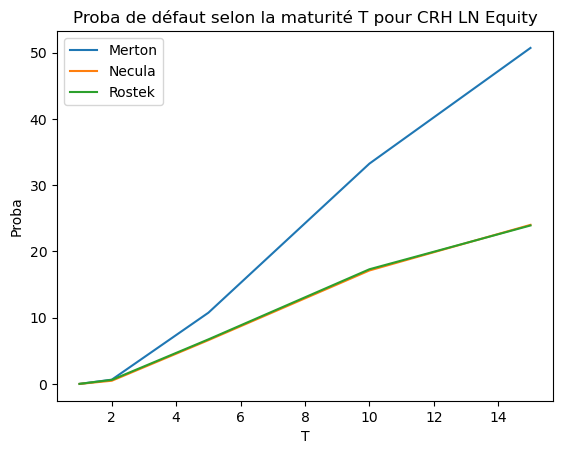

(array([1.02442518e-02, 6.50020899e-01, 1.07548603e+01, 3.32559393e+01,
        5.07117376e+01]),
 array([8.48185284e-03, 4.88567049e-01, 6.61003621e+00, 1.71280671e+01,
        2.40124631e+01]),
 array([1.91359067e-02, 6.15643901e-01, 6.73013940e+00, 1.73118161e+01,
        2.39185239e+01]),
 0.47687003051295623)

In [44]:
compute_proba_default(ticker = 'CRH LN Equity', metric = 'default')

ADP FP Equity Hurst : 0.5485682701511235


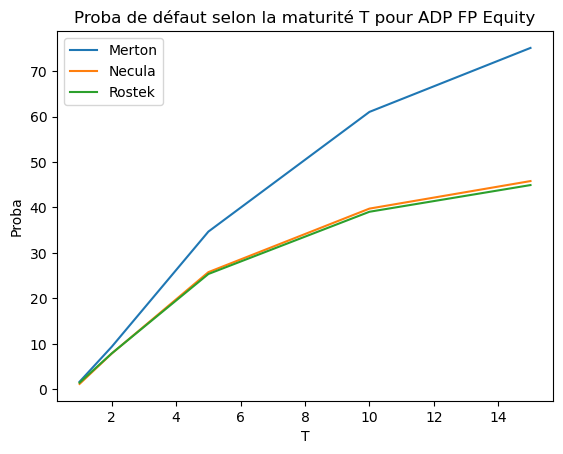

(array([ 1.64984178,  9.35982096, 34.68595653, 61.02077067, 75.09581233]),
 array([ 1.17006952,  7.86028552, 25.76580328, 39.74297303, 45.79946154]),
 array([ 1.43986296,  7.89426563, 25.35748799, 39.04820066, 44.92100295]),
 0.5485682701511235)

In [45]:
compute_proba_default(ticker = 'ADP FP Equity', metric = 'default')

CO FP Equity Hurst : 0.5219372904107252


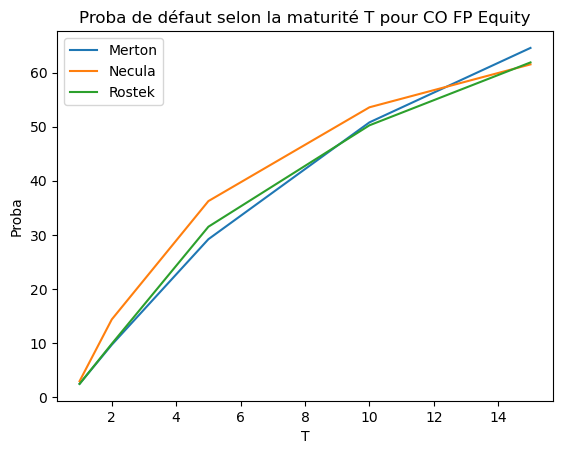

(array([ 2.45285949,  9.66939646, 29.19483548, 50.80495709, 64.57306948]),
 array([ 2.93415836, 14.35712392, 36.24478133, 53.59191559, 61.5269261 ]),
 array([ 2.42677771,  9.84460746, 31.50225728, 50.25825767, 61.89218673]),
 0.5219372904107252)

In [46]:
compute_proba_default(ticker = 'CO FP Equity', metric = 'default')

In [47]:
liste_equity = ['FGR FP Equity', 
                'CRH LN Equity', 
                'FR FP Equity' , 
                'ADP FP Equity' , 
                'DAI GY Equity', 
                'VIE FP Equity', 
                'LHA GY Equity', 
                'CO FP Equity']
export_latex(liste_equity)

Maturity : 1
FGR FP Equity & 0.6775443961281047 & 0.7741702414613472 & 0.7322951664498367 & 0.5628103887592388 \ 
CRH LN Equity & 0.010244251815039185 & 0.008481852838071458 & 0.01913590670383769 & 0.47687003051295623 \ 
FR FP Equity & 0.612518281156571 & 0.31576230717283993 & 0.32536691951730035 & 0.584156248183946 \ 
ADP FP Equity & 1.6498417787433217 & 1.1700695215815848 & 1.4398629597818458 & 0.5485682701511235 \ 
DAI GY Equity & 0.5407592354205737 & 0.782351660761238 & 0.4326435016051122 & 0.531447714308419 \ 
VIE FP Equity & 0.20764691236507815 & 0.08210284539613699 & 0.1852086674632325 & 0.5593901266942498 \ 
LHA GY Equity & 5.045293638677006 & 4.105967816328571 & 3.440894322206456 & 0.5486601890276613 \ 
CO FP Equity & 2.4528594853257646 & 2.9341583553714523 & 2.426777705473293 & 0.5219372904107252 \ 

Maturity : 2
FGR FP Equity & 5.429257808515842 & 7.706989298140221 & 6.224328689725322 & 0.5628103887592388 \ 
CRH LN Equity & 0.6500208992786138 & 0.48856704884063795 & 0.615643

In [48]:
liste_equity = ['FGR FP Equity', 
                'CRH LN Equity', 
                'FR FP Equity' , 
                'ADP FP Equity' , 
                'DAI GY Equity', 
                'VIE FP Equity', 
                'LHA GY Equity', 
                'CO FP Equity']
export_latex(liste_equity, metric = 'sigma')

Maturity : 1
FGR FP Equity & 0.14629985312805002 & 0.18118631838425397 & 0.15526200746295532 \ 
CRH LN Equity & 0.30316446572935823 & 0.32071638059519 & 0.32738814418305334 \ 
FR FP Equity & 0.31903762757949355 & 0.3420085051771099 & 0.3273166393778226 \ 
ADP FP Equity & 0.32198362127574914 & 0.3539652611074922 & 0.34887848558359463 \ 
DAI GY Equity & 0.10756282486139618 & 0.1415340910446852 & 0.1072552473756685 \ 
VIE FP Equity & 0.1610493765731737 & 0.17675662347375018 & 0.16582010657604598 \ 
LHA GY Equity & 0.21553016297104222 & 0.2443267143070337 & 0.21244398556087465 \ 
CO FP Equity & 0.07097575961936167 & 0.09380049080559116 & 0.07173818571860234 \ 

Maturity : 2
FGR FP Equity & 0.1523628928830374 & 0.1918925925409293 & 0.16576276151665098 \ 
CRH LN Equity & 0.3066906136706481 & 0.3301473559407961 & 0.3321735831866197 \ 
FR FP Equity & 0.338540696646771 & 0.36768420336274504 & 0.3563252658781593 \ 
ADP FP Equity & 0.3325699796044878 & 0.3734674965269168 & 0.3679066412907556 \ 
D

## Vérification de nos résultats

### Inversion de la formule

In [49]:
def bs_call_fractionnal(S, K, T, r, sigma, H, t=0):
    T_t = T - t
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * ((T_t)**(2*H))) / (sigma * ((T_t)**H))
    d2 = d1 - sigma * ((T_t)**H)
    
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T_t) * norm.cdf(d2))
    return call_price

def BSM_H_rostek_check(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5):
    frequency = []
    for d in delta:
        frequency.append(252 // d)
    company_debt = debt[[ticker]].iloc[0, 0]
    company_market_cap = market_cap[[ticker]].iloc[:, 0]
    sigma_A_former = 0
    H = H0
    roH= ro_h(H)
    sigma_E = np.std(np.diff(np.log(company_market_cap), n=1)) * np.sqrt(frequency[0])
    sigma_A = sigma_E

    n_iter = 1
    while np.abs(sigma_A - sigma_A_former) > epsilon:
        #print("Iteration ", n_iter)
        asset_values = {}
        for f in frequency:
            fasset_values = []
            n = company_market_cap.shape[0]
            days = []
            for i in range(n):
                if i % (n // f) == 0:
                    days.append(i)
            for day in days:
                t = day / n
                equity_value = company_market_cap[day]
                # find zero of Merton function, ie asset_value at the current_time
                fasset_values.append(optimize.newton(merton_formula_rostek, company_debt,
                                                     args=(rf, t, 1 + T, H, company_debt, equity_value, sigma_A, roH),
                                                     maxiter=100))
            asset_values[f] = fasset_values

        # update values
        Var = []
        for i, f in enumerate(frequency):
            Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )# *f)

        Mean = []
        for i, f in enumerate(frequency):
            Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))  # *f)

        n_iter += 1
        #print("update values")
        #sigma_A, sigma_A_former, H = update_values_regression_fixed_intercept(Var, delta, sigma_A, n_iter, False)
        sigma_A, sigma_A_former, H = update_values_regression(Var, delta, sigma_A, n_iter, False)
        #print(f"sigma= {sigma_A}, H={H}")
    return asset_values, sigma_A, H


ticker = "CRH LN Equity"
S, sigma, H = BSM_H_rostek_check(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5)   
K = debt[ticker].values[0]     
T = 1        
r = 0    

V_E = bs_call_fractionnal(S[252], K, T, r, sigma, H)

print(f"Results for Ticker {ticker} at T={T}")
print("Implied Equity Value", V_E[-1])
print("Real Equity Value", market_cap[ticker].values[-1])

Results for Ticker CRH LN Equity at T=1
Implied Equity Value 23439.961052185892
Real Equity Value 23440.1171


Text(0.5, 1.0, 'Difference between implied Equity Value and Real Equity Value')

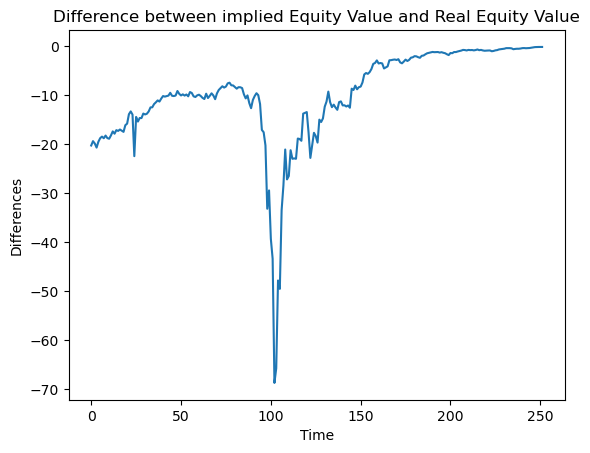

In [50]:
equity_differences = V_E - market_cap[ticker].values
plt.plot(equity_differences)
plt.xlabel("Time")
plt.ylabel("Differences")
plt.title("Difference between implied Equity Value and Real Equity Value")

Results for Ticker FR FP Equity at T=1
Implied Equity Value 6538.2445479060425
Real Equity Value 6539.3268


Text(0.5, 1.0, 'Difference between implied Equity Value and Real Equity Value')

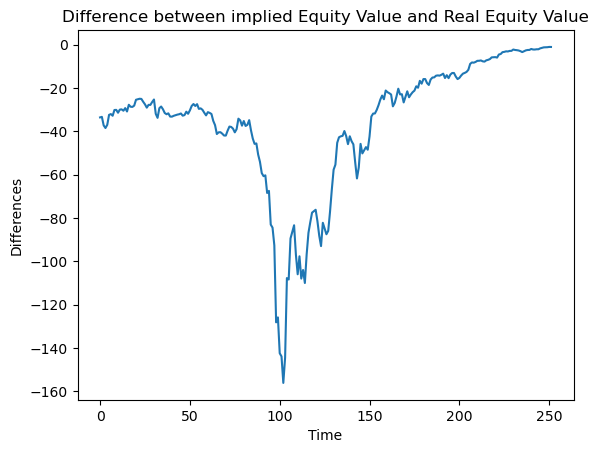

In [51]:
ticker = "FR FP Equity"
S, sigma, H = BSM_H_rostek_check(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5)   
K = debt[ticker].values[0]     
T = 1        
r = 0    

V_E = bs_call_fractionnal(S[252], K, T, r, sigma, H)

print(f"Results for Ticker {ticker} at T={T}")
print("Implied Equity Value", V_E[-1])
print("Real Equity Value", market_cap[ticker].values[-1])
equity_differences = V_E - market_cap[ticker].values
plt.plot(equity_differences)
plt.xlabel("Time")
plt.ylabel("Differences")
plt.title("Difference between implied Equity Value and Real Equity Value")

Results for Ticker CO FP Equity at T=1
Implied Equity Value 2191.5261680003714
Real Equity Value 2195.6312


Text(0.5, 1.0, 'Difference between implied Equity Value and Real Equity Value')

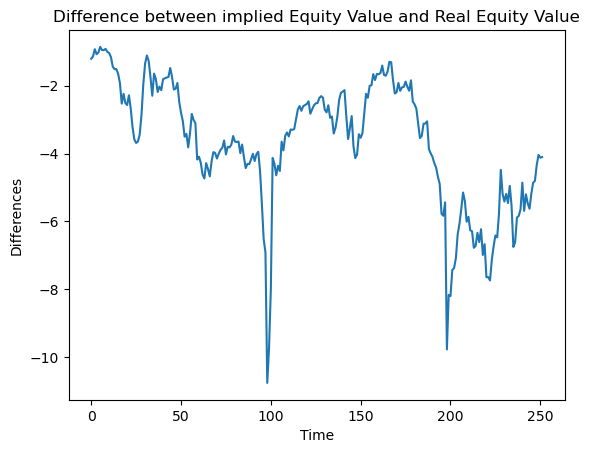

In [52]:
ticker = "CO FP Equity"
S, sigma, H = BSM_H_rostek_check(ticker, market_cap, debt, T=1, delta=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rf=0, epsilon=10e-3, H0=0.5)   
K = debt[ticker].values[0]     
T = 1        
r = 0    

V_E = bs_call_fractionnal(S[252], K, T, r, sigma, H)

print(f"Results for Ticker {ticker} at T={T}")
print("Implied Equity Value", V_E[-1])
print("Real Equity Value", market_cap[ticker].values[-1])
equity_differences = V_E - market_cap[ticker].values
plt.plot(equity_differences)
plt.xlabel("Time")
plt.ylabel("Differences")
plt.title("Difference between implied Equity Value and Real Equity Value")